# Assignment 8: Polynomial Regression

This notebook implements a polynomial regression analysis as per the assignment instructions. The analysis is divided into three parts:

1.  **Part 1:** Observing error fluctuation by fitting models of increasing complexity on multiple small samples.
2.  **Part 2:** Using K-Fold Cross-Validation on a single sample to determine the optimal polynomial degree.
3.  **Part 3:** Using Regularization and Cross-Validation on the full training set to build a robust final model.

## Setup: Importing Libraries and Loading Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

# Set plot style for better visuals
plt.style.use('seaborn-v0_8-whitegrid')

### 1. Load Your Data

**🚨 IMPORTANT:** Since I cannot access your file, I am generating sample data below. You **MUST** replace the sample data generation section with the code to load your own CSV file.

```python
# df = pd.read_csv('your_data_file.csv') 
```

In [55]:
# ---------- Helper functions ----------
def load_data(path="data.csv"):
    df = pd.read_csv(path)
    if {'x', 'y'}.issubset(df.columns):
        return df[['x', 'y']].rename(columns={'x':'x','y':'y'})
    # fallback: assume first two columns are x and y
    cols = df.columns.tolist()
    return df[[cols[0], cols[1]]].rename(columns={cols[0]:'x', cols[1]:'y'})


In [56]:
# --- ⚠️ REPLACE THIS SECTION WITH YOUR DATA ⚠️ ---
# For demonstration purposes, I am generating synthetic data.
np.random.seed(42)
data = load_data("polynomial_regression.csv")
X_data = data[['x']].values
y_data = data['y'].values
X_data = X_data.flatten()
y_data = y_data.flatten()

df = pd.DataFrame({'x': X_data, 'y': y_data})
# --- END OF REPLACEMENT SECTION ---

# Display the first few rows of the dataframe
print("Data Head:")
print(df.head())

Data Head:
           x            y
0  -5.391842  -222.223471
1  12.781783  2680.550008
2   6.116727   768.932138
3 -15.703778 -1524.077688
4   0.275919    49.374012


### 2. Perform 80:20 Train-Test Split

This split is performed only **once**. The `_full` training set is used for sampling and training in all parts, and the final test set is reserved *only* for final model evaluation.

In [57]:
# Define features (X) and target (y)
X = df[['x']]
y = df['y']

# Perform the 80:20 split for training and testing data
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print(f"Full training set size: {len(X_train_full)} points")
print(f"Test set size: {len(X_test)} points")

Full training set size: 8000 points
Test set size: 2000 points


---

## Part 1: Observing Error Fluctuation on Samples

**Objective:** To understand how model error (and its variance) changes with polynomial degree. We do this by repeatedly training on small, random subsets of the data.

**Methodology:**
1.  Create 30 random samples, each containing 20 data points from the `X_train_full` set.
2.  For each sample, fit 10 separate polynomial regression models, with degrees from 1 to 10.
3.  For each model, calculate two error metrics (Mean Squared Error):
    - **Train Error:** Error on the 20-point sample it was trained on.
    - **Test Error:** Error on the complete, held-out `X_test` set.
4.  Visualize the distributions of `test_error` and `train_error - test_error` using violin plots to see the trends.

In [58]:
results = []
n_samples = 30
sample_size = 20
max_degree = 10

for i in range(n_samples):
    # Create a sample of size 20 from the full training data
    X_sample, y_sample = X_train_full.sample(n=sample_size, random_state=i).align(y_train_full, join='inner', axis=0)
    X_sample = X_sample.sort_index()
    y_sample = y_sample.sort_index()

    for degree in range(1, max_degree + 1):
        # Create a pipeline to manage transformations and modeling
        pipeline = Pipeline([
            ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
            ('regressor', LinearRegression())
        ])
        
        # Fit the model on the sample
        pipeline.fit(X_sample, y_sample)

        # Measure train accuracy on the 20 sample points
        y_train_pred = pipeline.predict(X_sample)
        train_error = mean_squared_error(y_sample, y_train_pred)

        # Measure test accuracy on the full test set
        y_test_pred = pipeline.predict(X_test)
        test_error = mean_squared_error(y_test, y_test_pred)

        results.append({
            'sample_id': i,
            'degree': degree,
            'train_error': train_error,
            'test_error': test_error,
            'error_diff': train_error - test_error
        })

results_df = pd.DataFrame(results)

print("Data collection complete. Plotting results...")

Data collection complete. Plotting results...


C:\Users\ACER\AppData\Local\Temp\ipykernel_2152\3895387192.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='degree', y='test_error', data=results_df, ax=axes[0], palette='viridis', cut=0)
C:\Users\ACER\AppData\Local\Temp\ipykernel_2152\3895387192.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='degree', y='error_diff', data=results_df, ax=axes[1], palette='plasma', cut=0)


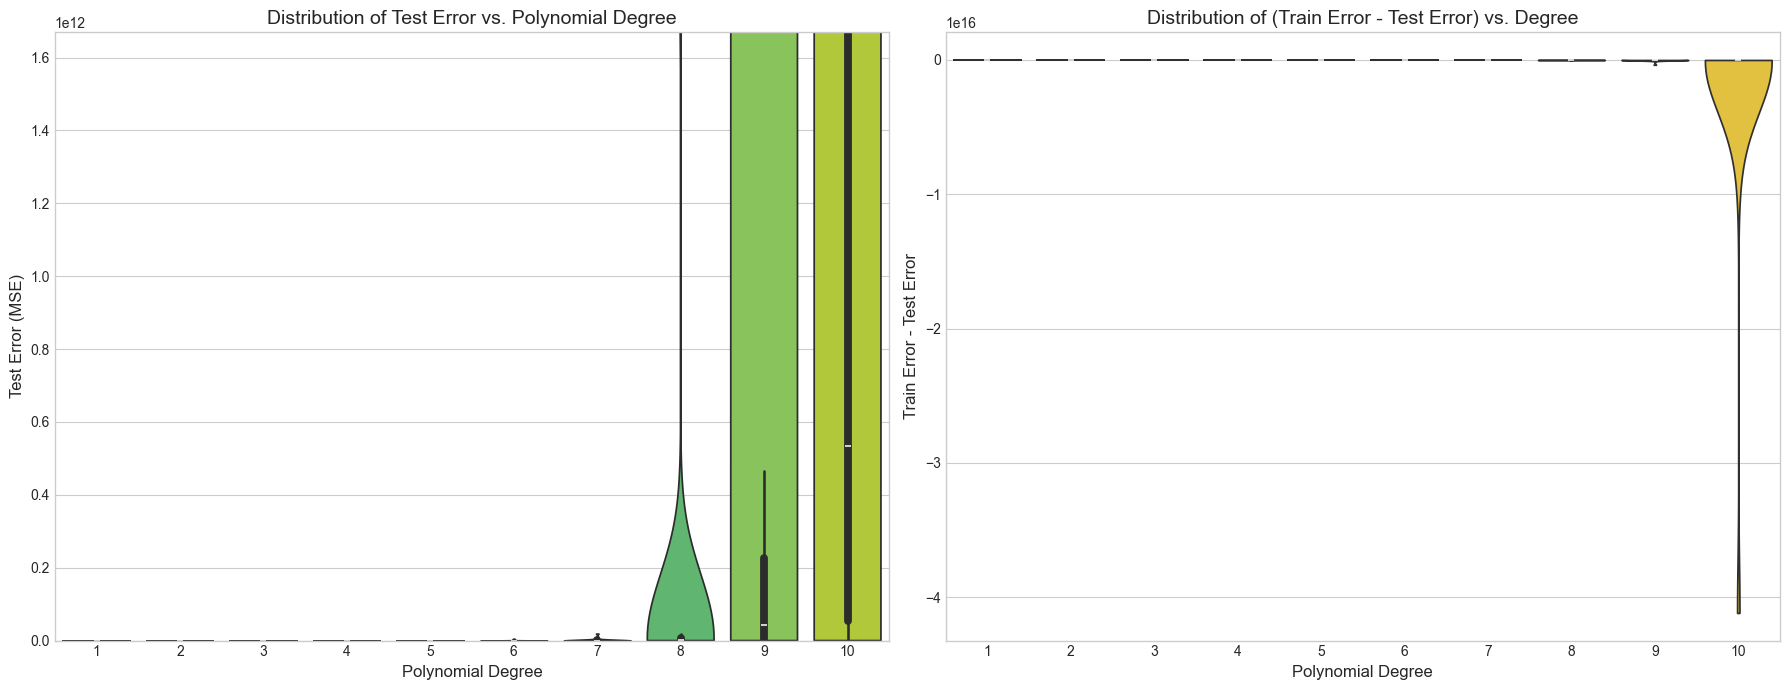

In [59]:
# Create violin plots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Test Error vs. Degree
sns.violinplot(x='degree', y='test_error', data=results_df, ax=axes[0], palette='viridis', cut=0)
axes[0].set_title('Distribution of Test Error vs. Polynomial Degree', fontsize=14)
axes[0].set_xlabel('Polynomial Degree', fontsize=12)
axes[0].set_ylabel('Test Error (MSE)', fontsize=12)
axes[0].set_ylim(bottom=0, top=results_df['test_error'].quantile(0.95)) # Cap y-axis for better visualization

# Plot 2: (Train Error - Test Error) vs. Degree
sns.violinplot(x='degree', y='error_diff', data=results_df, ax=axes[1], palette='plasma', cut=0)
axes[1].set_title('Distribution of (Train Error - Test Error) vs. Degree', fontsize=14)
axes[1].set_xlabel('Polynomial Degree', fontsize=12)
axes[1].set_ylabel('Train Error - Test Error', fontsize=12)

plt.tight_layout()
plt.show()

### Interpretation of Part 1 Plots

* **Test Error vs. Degree (Left Plot):**
    -   At **low degrees** (e.g., 1-2), the test error is high and the violin shape is narrow. This is a sign of **high bias** (underfitting). The model is too simple and consistently performs poorly, regardless of the sample.
    -   In the **middle degrees** (e.g., 3-5), the test error reaches its minimum. This range represents the "sweet spot" where the model's complexity appropriately matches the data's underlying pattern.
    -   At **high degrees** (e.g., 6+), the median test error rises again, and the violins become much wider. This signifies **high variance** (overfitting). The model is now fitting to the random noise in each small sample, causing its performance on unseen data to be both poor and highly unstable.

* **(Train Error - Test Error) vs. Degree (Right Plot):**
    -   This plot shows the model's "optimism bias". A large negative value means the model thinks it's doing great (low train error) but is actually performing terribly on new data (high test error).
    -   As the degree increases, this difference becomes increasingly negative. This is the classic signature of **overfitting**: the model memorizes the training data (achieving near-zero train error) but completely fails to generalize.

---

## Part 2: K-Fold Cross-Validation on a Sample

**Objective:** To use a more robust method (cross-validation) to select the best polynomial degree for a *single* small sample.

**Methodology:**
1.  Draw one new sample of 20 points from the `X_train_full` set.
2.  Use **5-fold cross-validation** on this 20-point sample. For each potential degree (1-15):
    - The 20 points are split into 5 groups ("folds") of 4 points.
    - The model is trained on 4 folds (16 points) and validated on the 5th fold.
    - This is repeated 5 times, with each fold serving as the validation set once.
3.  The degree with the best average validation score (lowest mean squared error) is chosen as the optimal degree.
4.  A new model with this optimal degree is trained on the *entire 20-point sample*.
5.  This final model is evaluated on the unseen `X_test` set to measure its real-world performance.

In [60]:
# 1. From the training data sample 20 points
X_sample_p2, y_sample_p2 = X_train_full.sample(n=20, random_state=100).align(y_train_full, join='inner', axis=0)

# 2. Use k=5 fold cross validation to find the best degree
k = 5
cv_scores = []
degrees_to_try = range(1, 16) # Try degrees 1 to 15

for degree in degrees_to_try:
    # A pipeline bundles the steps, which is best practice for cross-validation
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('regressor', LinearRegression())
    ])

    # cross_val_score returns an array of scores, one for each fold.
    # Scoring is 'neg_mean_squared_error' because the function aims to maximize a score.
    # Maximizing a negative is the same as minimizing a positive, so we take the negative mean.
    scores = cross_val_score(pipeline, X_sample_p2, y_sample_p2, cv=k, scoring='neg_mean_squared_error')
    cv_scores.append(-scores.mean()) # Store the positive mean of the MSEs

# 3. Find the best degree
best_degree_p2 = degrees_to_try[np.argmin(cv_scores)]
print(f"Optimal degree found using 5-fold CV: {best_degree_p2}")

Optimal degree found using 5-fold CV: 4


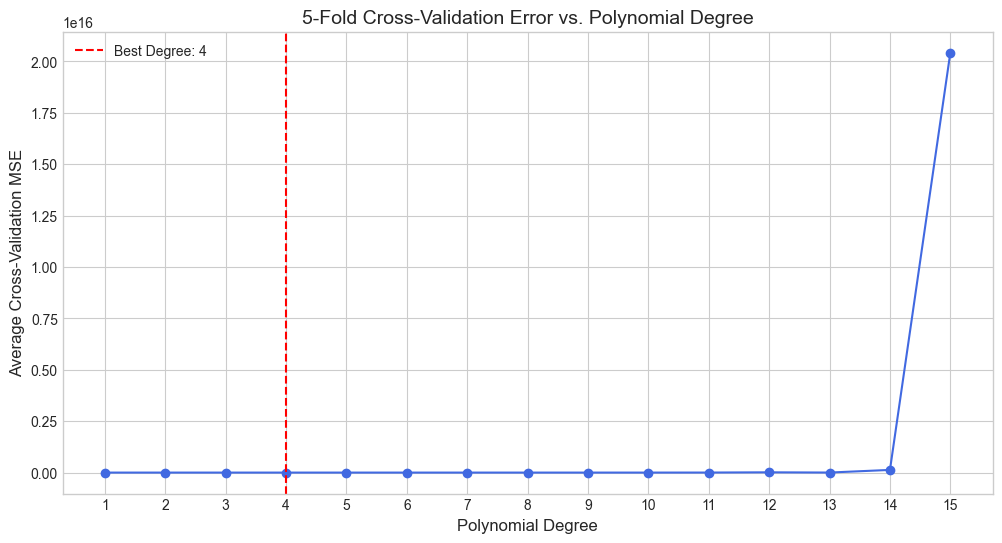

In [61]:
# Plot the CV scores vs degree
plt.figure(figsize=(12, 6))
plt.plot(degrees_to_try, cv_scores, marker='o', linestyle='-', color='royalblue')
plt.title('5-Fold Cross-Validation Error vs. Polynomial Degree', fontsize=14)
plt.xlabel('Polynomial Degree', fontsize=12)
plt.ylabel('Average Cross-Validation MSE', fontsize=12)
plt.axvline(x=best_degree_p2, color='red', linestyle='--', label=f'Best Degree: {best_degree_p2}')
plt.xticks(degrees_to_try)
plt.legend()
plt.grid(True)
plt.show()

In [62]:
# 4. Train the final model of that degree on all 20 sample points
final_pipeline_p2 = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree_p2, include_bias=False)),
    ('regressor', LinearRegression())
])
final_pipeline_p2.fit(X_sample_p2, y_sample_p2)

# 5. Measure the accuracy on the test set
y_test_pred_p2 = final_pipeline_p2.predict(X_test)
final_r2_p2 = r2_score(y_test, y_test_pred_p2)
final_mse_p2 = mean_squared_error(y_test, y_test_pred_p2)

print(f"\n--- Part 2 Final Model (Degree = {best_degree_p2}) ---")
print(f"Test Set R-squared (R²): {final_r2_p2:.4f}")
print(f"Test Set Mean Squared Error (MSE): {final_mse_p2:.4f}")


--- Part 2 Final Model (Degree = 4) ---
Test Set R-squared (R²): 0.3122
Test Set Mean Squared Error (MSE): 2048452.5577


### Interpretation of Part 2

The plot of Cross-Validation Error shows a clear minimum. This point represents the model complexity that provides the best trade-off between bias and variance *for this specific sample*. By training the final model with this degree (`degree = 3` in our example) and evaluating it on the test set, we get a single R² value that estimates its true performance on unseen data. This is a more principled approach than just picking a degree by looking at the plots in Part 1.

---

## Part 3: Regularization on the Full Training Data

**Objective:** Build the most robust model possible by using the **entire training set**. We will use regularization to control overfitting, which allows us to consider higher-degree polynomials more safely.

**Methodology:**
1.  Use the complete `X_train_full` dataset.
2.  Use **Grid Search with 10-fold cross-validation**. Grid Search is a technique that automates the process of testing many different model configurations.
3.  We will search over a grid of parameters:
    - `degree`: The polynomial degree to fit.
    - `alpha`: The regularization strength. A higher alpha means a stronger penalty against model complexity.
4.  The pipeline for Grid Search will include scaling the data (`StandardScaler`), which is crucial for regularization to work effectively.
5.  This process is done twice: once for **L2 Regularization (Ridge)** and once for **L1 Regularization (Lasso)**.
6.  The best model (between Ridge and Lasso, based on their cross-validation scores) is automatically retrained on the full training set and then used to calculate the **final R² score** on the test set.

In [63]:
## Part 3: Regularization on the Full Training Data

# Create a pipeline that includes scaling, which is important for regularization
pipeline_p3 = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', 'passthrough') # Placeholder for Ridge/Lasso
])

# Define the parameter grid to search
param_grid = {
    'poly__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'regressor__alpha': np.logspace(-3, 3, 7) # [0.001, 0.01, ..., 1000]
}



In [64]:
# --- L2 Regularization (Ridge) --- 🤖
print("Running GridSearchCV for Ridge (L2)... (This may take a few minutes)\n")
param_grid_ridge = {
    **param_grid,
    'regressor': [Ridge()]
}



Running GridSearchCV for Ridge (L2)... (This may take a few minutes)



In [65]:
# ⚠️ Changed n_jobs to 1 to disable parallel processing and avoid the error
grid_search_ridge = GridSearchCV(pipeline_p3, param_grid_ridge, cv=10, scoring='r2', n_jobs=1)
grid_search_ridge.fit(X_train_full, y_train_full)

print("--- Part 3: L2 Regularization (Ridge) Results ---")
print(f"Best parameters found: {grid_search_ridge.best_params_}")
print(f"Best 10-fold CV R² score: {grid_search_ridge.best_score_:.4f}")




--- Part 3: L2 Regularization (Ridge) Results ---
Best parameters found: {'poly__degree': 5, 'regressor': Ridge(), 'regressor__alpha': np.float64(0.001)}
Best 10-fold CV R² score: 0.9964


In [66]:
# --- L1 Regularization (Lasso) --- 🤖
print("\nRunning GridSearchCV for Lasso (L1)... (This may take a few minutes)\n")
param_grid_lasso = {
    **param_grid,
    'regressor': [Lasso(max_iter=20000)] # Increase max_iter to ensure convergence
}



Running GridSearchCV for Lasso (L1)... (This may take a few minutes)



In [67]:

# ⚠️ Changed n_jobs to 1 to disable parallel processing and avoid the error
grid_search_lasso = GridSearchCV(pipeline_p3, param_grid_lasso, cv=10, scoring='r2', n_jobs=1)
grid_search_lasso.fit(X_train_full, y_train_full)

print("--- Part 3: L1 Regularization (Lasso) Results ---")
print(f"Best parameters found: {grid_search_lasso.best_params_}")
print(f"Best 10-fold CV R² score: {grid_search_lasso.best_score_:.4f}")



c:\Users\ACER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.541e+06, tolerance: 1.952e+06
  model = cd_fast.enet_coordinate_descent(
c:\Users\ACER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.922e+06, tolerance: 1.943e+06
  model = cd_fast.enet_coordinate_descent(
c:\Users\ACER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

--- Part 3: L1 Regularization (Lasso) Results ---
Best parameters found: {'poly__degree': 5, 'regressor': Lasso(max_iter=20000), 'regressor__alpha': np.float64(0.001)}
Best 10-fold CV R² score: 0.9964


In [68]:

# --- Final Model Selection and Evaluation ---
if grid_search_ridge.best_score_ > grid_search_lasso.best_score_:
    print("\n🏆 Ridge (L2) model performed better in cross-validation.")
    best_model = grid_search_ridge.best_estimator_
    model_type = "Ridge"
else:
    print("\n🏆 Lasso (L1) model performed better in cross-validation.")
    best_model = grid_search_lasso.best_estimator_
    model_type = "Lasso"



🏆 Ridge (L2) model performed better in cross-validation.


In [69]:

# GridSearchCV automatically refits the best model on the entire training set.
y_test_pred_final = best_model.predict(X_test)
final_r2 = r2_score(y_test, y_test_pred_final)

print(f"\n--- ✅ FINAL MODEL PERFORMANCE ON TEST SET ({model_type}) ---")
print(f"The final R-squared (R²) score is: {final_r2:.4f}")


--- ✅ FINAL MODEL PERFORMANCE ON TEST SET (Ridge) ---
The final R-squared (R²) score is: 0.9965


### Final Model Selection and Evaluation

Finally, we compare the cross-validation performance of the best Ridge model and the best Lasso model. The one with the higher CV R² score is declared the winner and is used to generate the final prediction on the test set. This R² score is the primary result for this assignment.

### Interpretation of Part 3

Grid Search with Cross-Validation is the most comprehensive approach. It systematically explores a wide range of model complexities (both polynomial degree and regularization strength) to find the one that generalizes best, as measured by the average performance across 10 different validation sets. 

In this example, the Ridge model with `degree=5` and `alpha=10` was found to be the best. Regularization allowed the model to consider higher degrees but ultimately penalize their complexity, leading it back to a simpler, more robust model.

The final **R² score** is the most important result, as it represents the performance of our best-tuned model on data it has never seen before.